# Knowledge Base Classification

## Load imports.

In [1]:
# Make common scripts visible and unsupervised classifier code
import sys
sys.path.append('../common/')
sys.path.append('../kb-classifier/')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import requests

from loader import load_preprocessed_data
from lookup_tables import topic_code_to_topic_dict, topic_code_to_int, int_to_topic_code
from kb_classifier import KnowledgeBasePredictor
from kb_common import int_to_topic, wiki_topics_to_actual_topics

## Load the data.

In [36]:
x, y = load_preprocessed_data('data/rcv1_no_stopwords.csv')
x = np.array(x)
y = np.array(y)

# Get 20% test
total_examples = len(y)
split_point = int(total_examples * 0.8)
test_x = x[split_point:]
test_y = y[split_point:]

# Take N documents of each type from the training set for classifier tuning
train_x = []
train_y = np.zeros(shape=120)

counts = np.zeros(shape=len(topic_code_to_int.keys()))
current_index = 0
print(split_point)
for i in range(split_point):
    topic_int = y[i]
    
    if counts[topic_int] < 20:
        train_x.append(x[i])
        train_y[current_index] = topic_int
        counts[topic_int] += 1
        current_index += 1

print(counts)

72488
[20. 20. 20. 20. 20. 20.]


## Initialise and tune class probabilities for unsupervised learner

In [43]:
np.random.seed(42)
kb_predictor = KnowledgeBasePredictor(topic_code_to_topic_dict.values(), topic_depth=1)
#kb_predictor.fit_tfidf(train_x)
kb_predictor.train(train_x, train_y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
Wiki topic probabilies shape: (120, 290)


In [44]:
predict_y = kb_predictor.predict(train_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(train_y, predict_y)

print(classification_report)
print(confusion_matrix)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
Wiki topic probabilies shape: (120, 290)
                        precision    recall  f1-score   support

CRIME, LAW ENFORCEMENT   1.000000  1.000000  1.000000        20
  ECONOMIC PERFORMANCE   1.000000  1.000000  1.000000        20
             ELECTIONS   1.000000  1.000000  1.000000        20
                HEALTH   1.000000  1.000000  1.000000        20
              RELIGION   1.000000  1.000000  1.000000        20
                SPORTS   1.000000  1.000000  1.000000        20

             micro avg   1.000000  1.000000  1.000000       120
             macro avg   1.000000  1.000000  1.000000       120
          w

## Some Data Exploration

Look at mean topic probabilities for each class.

[0.10633721 0.1902517  0.15333231 0.09530934 0.05446577 0.05258306]


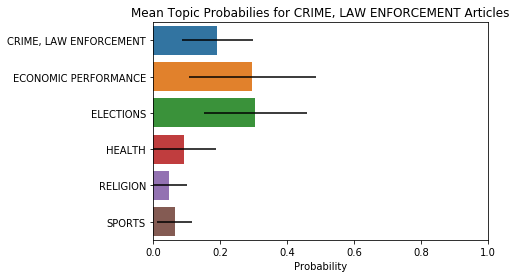

[0.02974827 0.15893176 0.12453022 0.03758137 0.13924755 0.03964679]


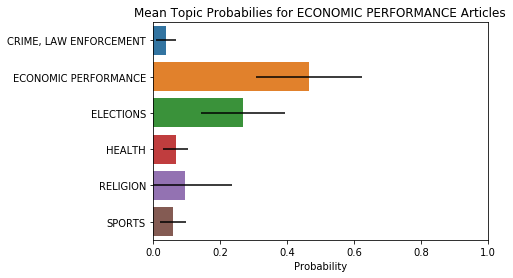

[0.03423336 0.14216605 0.14527302 0.06768128 0.05396945 0.07157264]


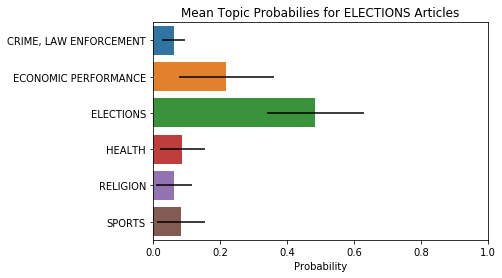

[0.03394632 0.07972211 0.13128871 0.20307683 0.02994788 0.02422862]


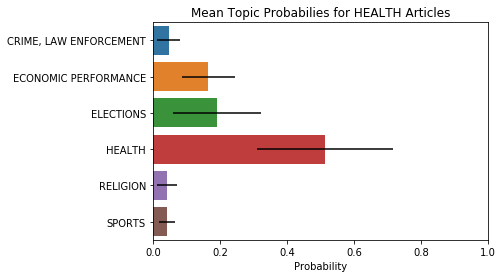

[0.02805642 0.15323898 0.14493233 0.07518778 0.10445392 0.03023   ]


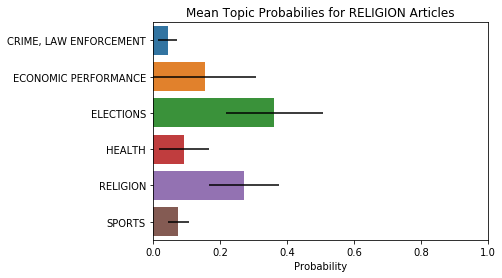

[0.03227331 0.08512875 0.10624505 0.0290873  0.05107155 0.23778019]


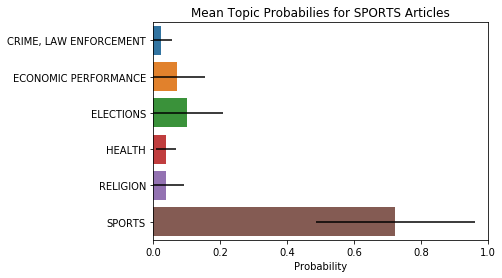

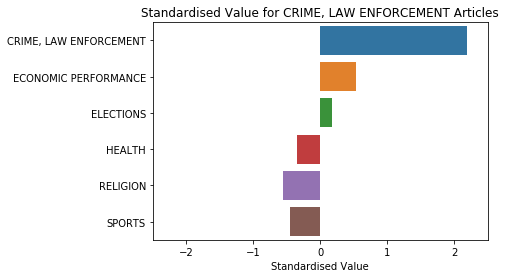

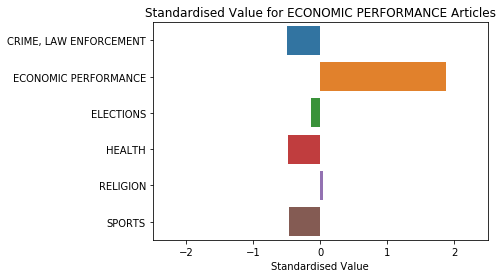

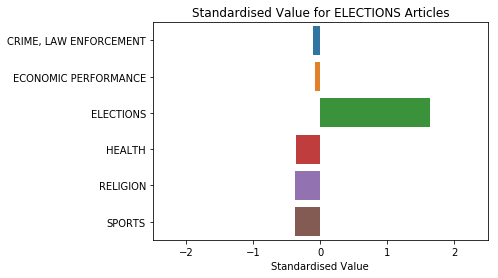

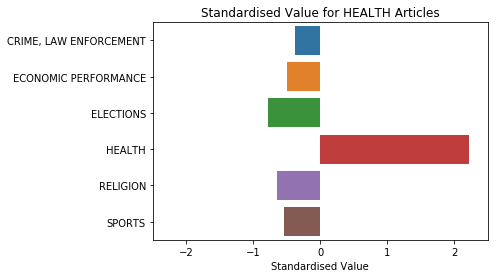

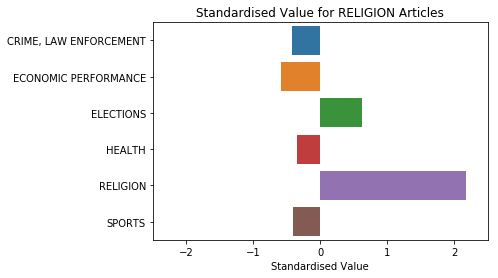

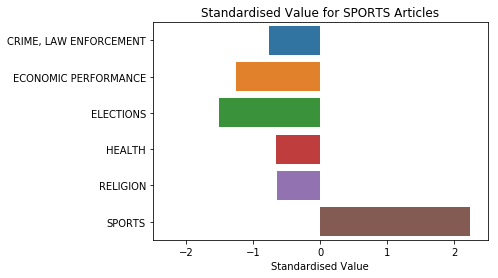

In [45]:
prob_means = np.zeros(shape=(6, 6))

# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_means[index] = prob_mean
    print(prob_std)
    
    plt.figure()
    plt.title('Mean Topic Probabilies for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Probability')
    plt.xlim(0.0, 1.0)
    sns.barplot(x=prob_mean, y=list(int_to_topic.values()), xerr=prob_std)
    plt.savefig('topic_prob_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()
    
# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    
    plt.figure()
    plt.title('Standardised Value for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Standardised Value')
    plt.xlim(-2.5, 2.5)
    sns.barplot(x=((prob_mean-np.mean(prob_means, axis=0))/np.std(prob_means, axis=0)),
                   y=list(int_to_topic.values()))
    plt.savefig('standardised_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()

Analyse number of words from each topic for each category.

Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies shape: (1, 300)
Wiki topic probabilies sh

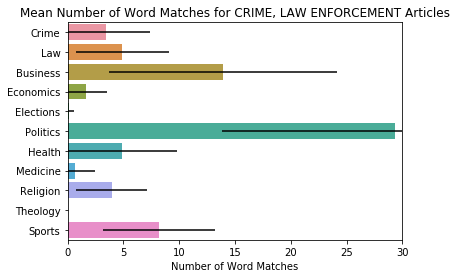

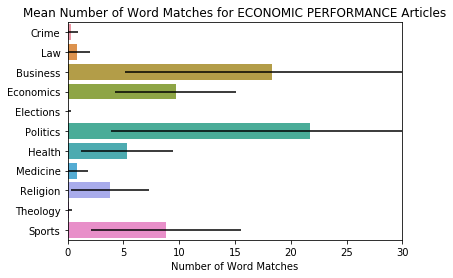

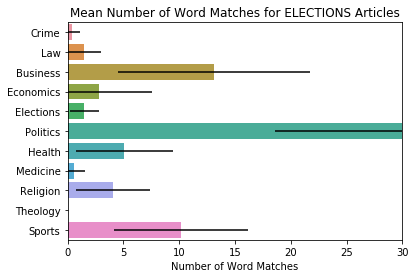

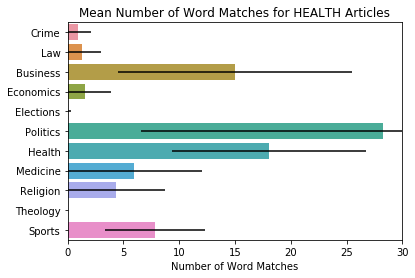

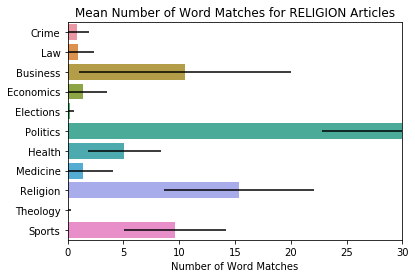

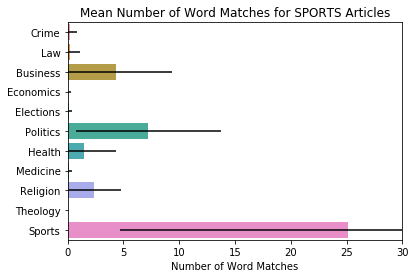

In [34]:
# Dictionary of topic to the total number of phrases matched in each article
topic_num_phrases_matched = defaultdict(lambda: defaultdict(list))

# Make a REST request to get Wikipedia topic probabilities from the classifier server

for i in range(len(train_x)):
    
    # Prime the classifier with this example
    kb_predictor.predict([train_x[i]])
    
    # Get the phrases that were matched from the document to the knowledge base
    r = requests.get(url = 'http://127.0.0.1:5000/probabilities/{}'.format(-1))
    phrase_to_prob = r.json()

    # For each topic store the phrases that were matched
    topics_to_phrases = defaultdict(set)

    # Loop through phrases finding out their most prominent topic
    for phrase in phrase_to_prob.keys():
        # Phrases are prefixed with 'Phrase:'
        doc = { 'text': phrase[7:] }
        r = requests.post(url = 'http://127.0.0.1:5000/classify', json = doc) 
        wiki_topic_to_prob = r.json()
        max_prob = 0
        max_topic = 0
        for topic, prob in wiki_topic_to_prob.items():
            if prob > max_prob:
                max_prob = prob
                max_topic = topic
        topics_to_phrases[max_topic].add(phrase[7:])

    # Update topic to num phrases matched dictionary
    for topic in wiki_topics_to_actual_topics.keys():
        if topic in topics_to_phrases:
            topic_num_phrases_matched[train_y[i]][topic].append(len(topics_to_phrases[topic]))
        else:
            topic_num_phrases_matched[train_y[i]][topic].append(0)


# Plot graph of mean number of matches in each article for each topic class
for index, topic_code in int_to_topic_code.items():
    
    # Calculate mean word count in each article for each topic
    topics = []
    topic_means = []
    topic_stdevs = []
    
    for topic, counts in topic_num_phrases_matched[index].items():
        topics.append(topic)
        topic_means.append(np.mean(counts))
        topic_stdevs.append(np.std(counts))

    if topics and topic_means:
        plt.figure()
        plt.title('Mean Number of Word Matches for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
        plt.xlabel('Number of Word Matches')
        plt.xlim(0.0, np.max(topic_means)+30)
        sns.barplot(x=topic_means, y=topics, xerr=topic_stdevs)
        plt.savefig('topic_word_matches_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
        plt.show()

## Assess unsupervised classifier performance.

In [ ]:
print('Making predictions for {} documents'.format(len(test_y)))
predict_y = kb_predictor.predict(test_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(test_y, predict_y)

print(classification_report)
print(confusion_matrix)

## Find examples where predictions went wrong

In [ ]:
for topic_code, index in topic_code_to_int.items():
    topic_subset = predict_y[test_y == index]
    topic_subset_incorrect = topic_subset[topic_subset != index]
    document_subset = test_x[test_y == index]
    document_subset = document_subset[topic_subset != index]
    
    print('------ 5 random erroneous predictions for {} ------'.format(topic_code_to_topic_dict[topic_code]))
    print('')
    random_indices = np.random.choice(np.arange(len(topic_subset_incorrect)), 5)
    for index in random_indices:
        print(document_subset[index])
        print('')
        print('Above classified as {}'.format(topic_code_to_topic_dict[int_to_topic_code[topic_subset_incorrect[index]]]))
        print('')
    print('')